In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import multivariate_normal
import gpflow
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import pickle
import sys
sys.path.insert(1, "../ipsc_gp_clustering")
from splitgpm import SplitGPM
from utils import gen_gsea_df
import gpflow.training.monitor as mon
import os
import matplotlib.pyplot as plt

In [33]:
C=10
G=5000
T=10
K1=1
K2=5
N=C*T

In [34]:
X = np.loadtxt("../data/endo.X.txt")
Y = np.loadtxt("../data/endo.Y.txt")

In [35]:
def normalize(X):
    return X / X.sum(1)[:, None]

In [36]:
gpflow.reset_default_graph_and_session()
name = 'test'
minibatch_size = 500
W1_init = normalize(np.random.random(size=(C, K1)))
W2_init = normalize(np.random.random(size=(G, K2)))

In [37]:
with gpflow.defer_build():
    kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
    Z = np.linspace(0, 1, T)[:, None].astype(np.float64)
    feature = gpflow.features.InducingPoints(Z)
    feature = mf.SharedIndependentMof(feature)

    model = SplitGPM(X, Y, np.log(W1_init + 1e-5), np.log(W2_init + 1e-5), kernel, gpflow.likelihoods.Gaussian(), feat=feature, minibatch_size=minibatch_size, name=name)
model.compile()

Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


In [38]:
model.W1.set_trainable(True)  # learn cell assignments
model.W2.set_trainable(True)  # learn gene assignments
model.feature.set_trainable(True)  # move inducing points
model.kern.set_trainable(True)  # learn kernel parameters
model.likelihood.set_trainable(True)  # learn likelihood parameters

In [39]:
adam = gpflow.train.AdamOptimizer(0.005)
adam.minimize(model, maxiter=10000)

In [40]:
Xnew = np.linspace(0, 1, 100)[:, None]
mu, var = model.predict_f(Xnew)

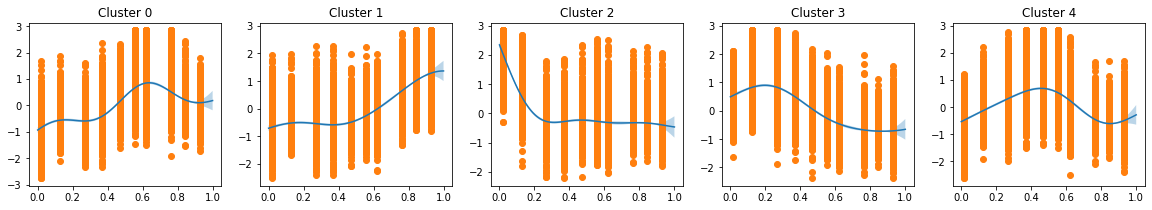

In [53]:
fig, ax = plt.subplots(1,5, figsize=(20,3))

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        # if x axis necessary use int(l/5)
        ax[l%5].plot(Xnew, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
        
        assigned_points = np.logical_and(a1 == k, a2 == l)
        ax[l%5].scatter(X[assigned_points, 0], Y[assigned_points])

In [54]:
with open("../data/genedict.endo.pickle", 'rb') as f:
    genedict = pickle.load(f)
    f.close()

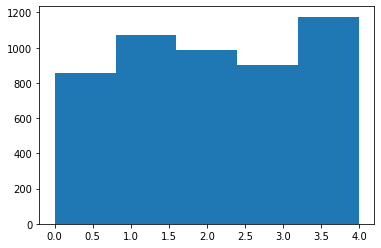

In [44]:
plt.hist(a2[:5000], bins=5)
plt.show()

In [45]:
assignments = model.W2.value.argmax(1)
gene_names = np.array(list(genedict.keys()))
results = gen_gsea_df(assignments, gene_names, 'gsea_output', threshold=1e-2, rerun=True)

In [46]:
idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[:, 'bonferonni-adjusted']]

,0,1,3
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_TNFA_SIGNALING_VIA_NFKB,1,0.0082276,1
HALLMARK_G2M_CHECKPOINT,1,1,1.03838e-21
HALLMARK_APOPTOSIS,1,1.12079e-07,1
HALLMARK_ANDROGEN_RESPONSE,1,0.00292381,1
HALLMARK_MTORC1_SIGNALING,1,1,0.00278851
HALLMARK_E2F_TARGETS,1,1,6.00013e-31
HALLMARK_MYC_TARGETS_V1,1,1,3.47853e-13
HALLMARK_MYC_TARGETS_V2,1,1,0.00832378
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.00279859,1,1
